In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines
import seaborn as sns
import requests
import warnings
import miceforest as mf
from miceforest import ImputationKernel
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



path = 'data/AirQualityUCI.csv'


data = pd.read_csv(path,sep=';')
data.drop_duplicates(inplace=True)
data.drop(columns=['Unnamed: 15', 'Unnamed: 16'], inplace=True)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888"


First we see that we need to take care of some numeric values written with commas.

In [2]:
comma_replace_cols = ['CO(GT)','C6H6(GT)','T','RH','AH']

for column in comma_replace_cols:
    data[column] = data[column].str.replace(',', '.').astype(float)

Now lets replace missing values markes as -200, with null values. We will also take a look at how many rows with given number of missing positions we have.

In [3]:
data = data.replace(-200, np.nan)
null_counts_per_row = data.isnull().sum(axis=1)
count_of_nulls = null_counts_per_row.value_counts()
print(count_of_nulls)

1     6138
4     1195
0      827
2      467
3      364
10     291
13      31
9       26
12      12
11       6
Name: count, dtype: int64


Lets check how much data is missing in each feature.

In [4]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)


Date              0.000000
Time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64


Now lets convert 'Date' column into two columns - one with month, and second with year.

In [5]:
data[['Day','Month', 'Year']] = data['Date'].str.split('/', expand=True)
data.drop(columns=['Day','Date'], inplace=True)

# Converting columns to numeric
data['Year'] = pd.to_numeric(data['Year'], errors='coerce', downcast='integer')
data['Month'] = pd.to_numeric(data['Month'], errors='coerce', downcast='integer')

month_names = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

data['Month'] = data['Month'].map(month_names)

columns = list(data.columns)
columns.insert(0, columns.pop(columns.index('Month')))
columns.insert(0, columns.pop(columns.index('Year')))
data = data[columns]
data.head()

,Year,Month,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004,March,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004,March,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004,March,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004,March,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004,March,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [6]:
data['Month'].unique()

array(['March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'January', 'February'],
      dtype=object)

Split columns into categorical ones and numerical ones.

In [7]:
categorical_columns = data.select_dtypes(include=['int32','object', 'category']).columns.to_numpy()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.to_numpy()
numerical_columns = numerical_columns[numerical_columns != 'Year']
categorical_columns = np.append('Year', categorical_columns)

#numerical_columns = numerical_columns[numerical_columns != 'C6H6(GT)']
print(categorical_columns)
print(numerical_columns)

['Year' 'Month' 'Time']
['CO(GT)' 'PT08.S1(CO)' 'NMHC(GT)' 'C6H6(GT)' 'PT08.S2(NMHC)' 'NOx(GT)'
 'PT08.S3(NOx)' 'NO2(GT)' 'PT08.S4(NO2)' 'PT08.S5(O3)' 'T' 'RH' 'AH']


# EDA

## <p style="font-size:30px">1. Univariate analysis</p> 

Histograms of categorical features:

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'CO(GT)'}>,
        <Axes: title={'center': 'PT08.S1(CO)'}>,
        <Axes: title={'center': 'NMHC(GT)'}>],
       [<Axes: title={'center': 'C6H6(GT)'}>,
        <Axes: title={'center': 'PT08.S2(NMHC)'}>,
        <Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>],
       [<Axes: title={'center': 'NO2(GT)'}>,
        <Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'PT08.S5(O3)'}>,
        <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'RH'}>, <Axes: title={'center': 'AH'}>,
        <Axes: >, <Axes: >]], dtype=object)

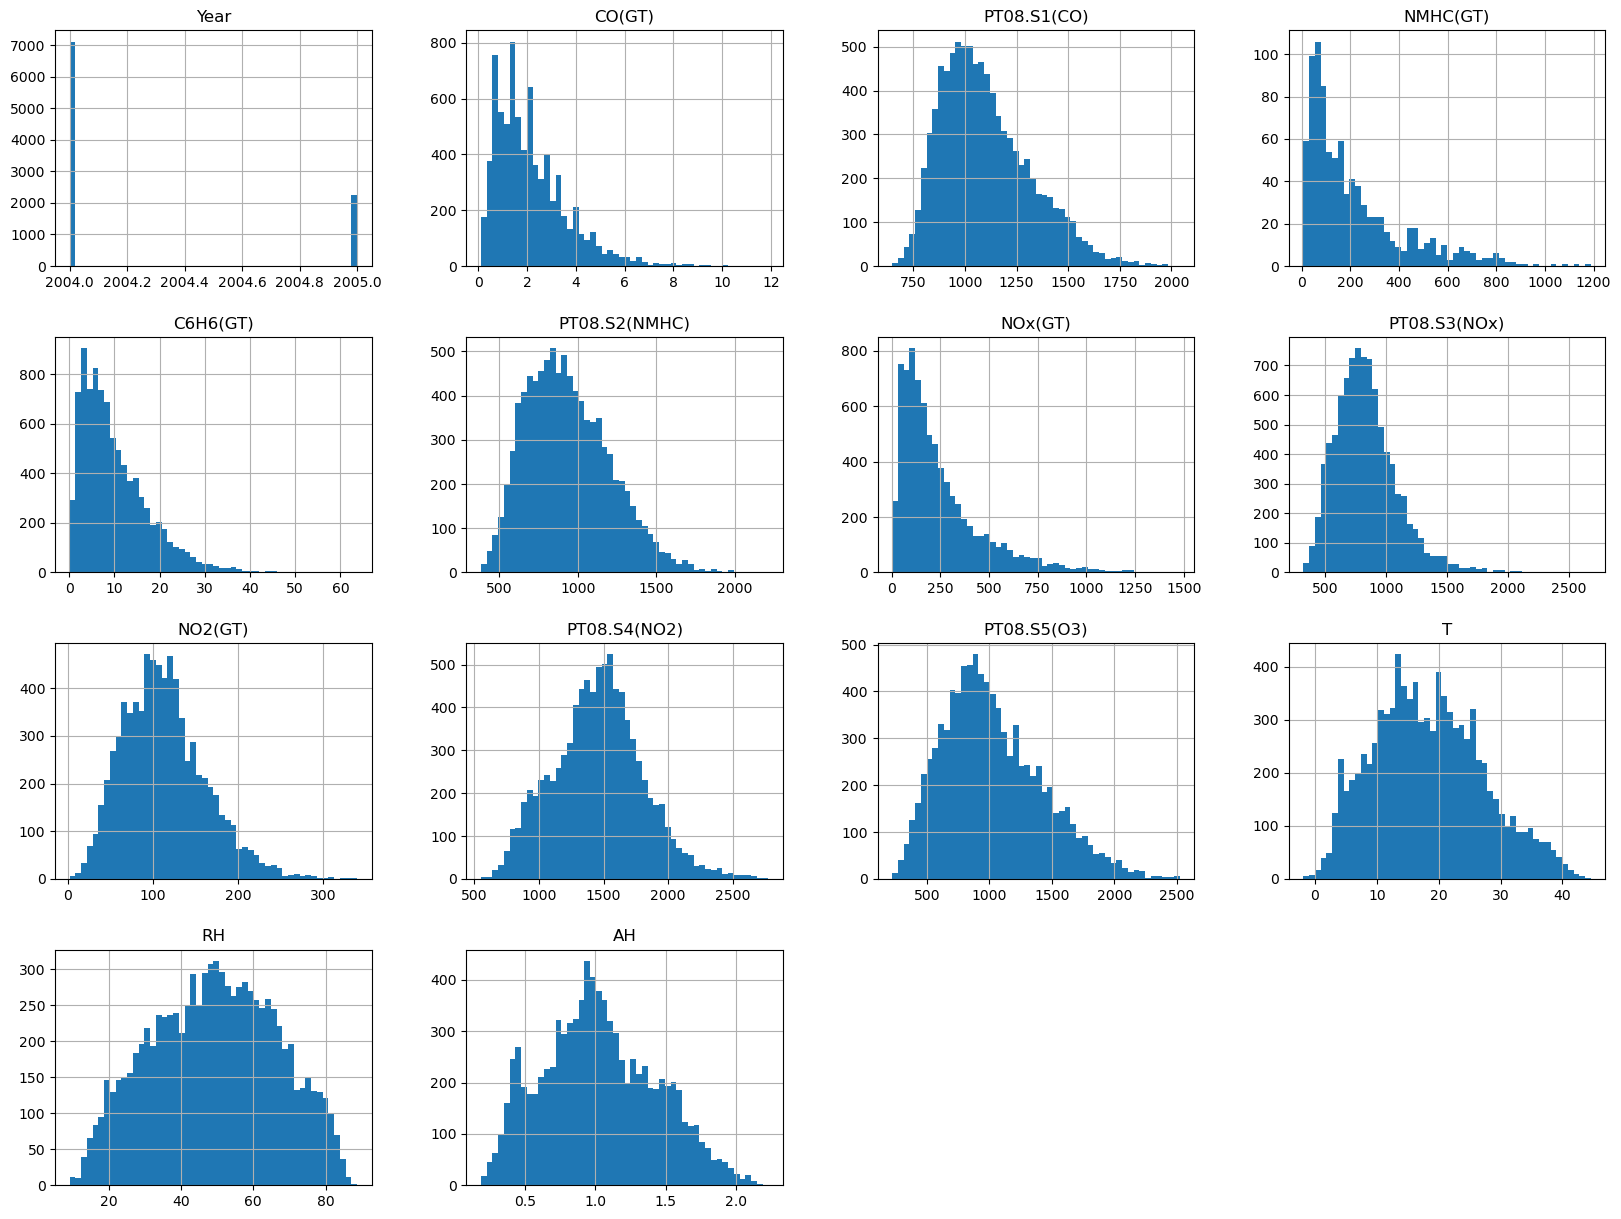

In [8]:
data.hist(bins=50, figsize=(20,15))

And additionally histograms with visualization for each month.

C:\Users\opala\AppData\Local\Temp\ipykernel_16860\1253542569.py:38: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x=column, hue='Month', multiple='stack', ax=ax[row,col])


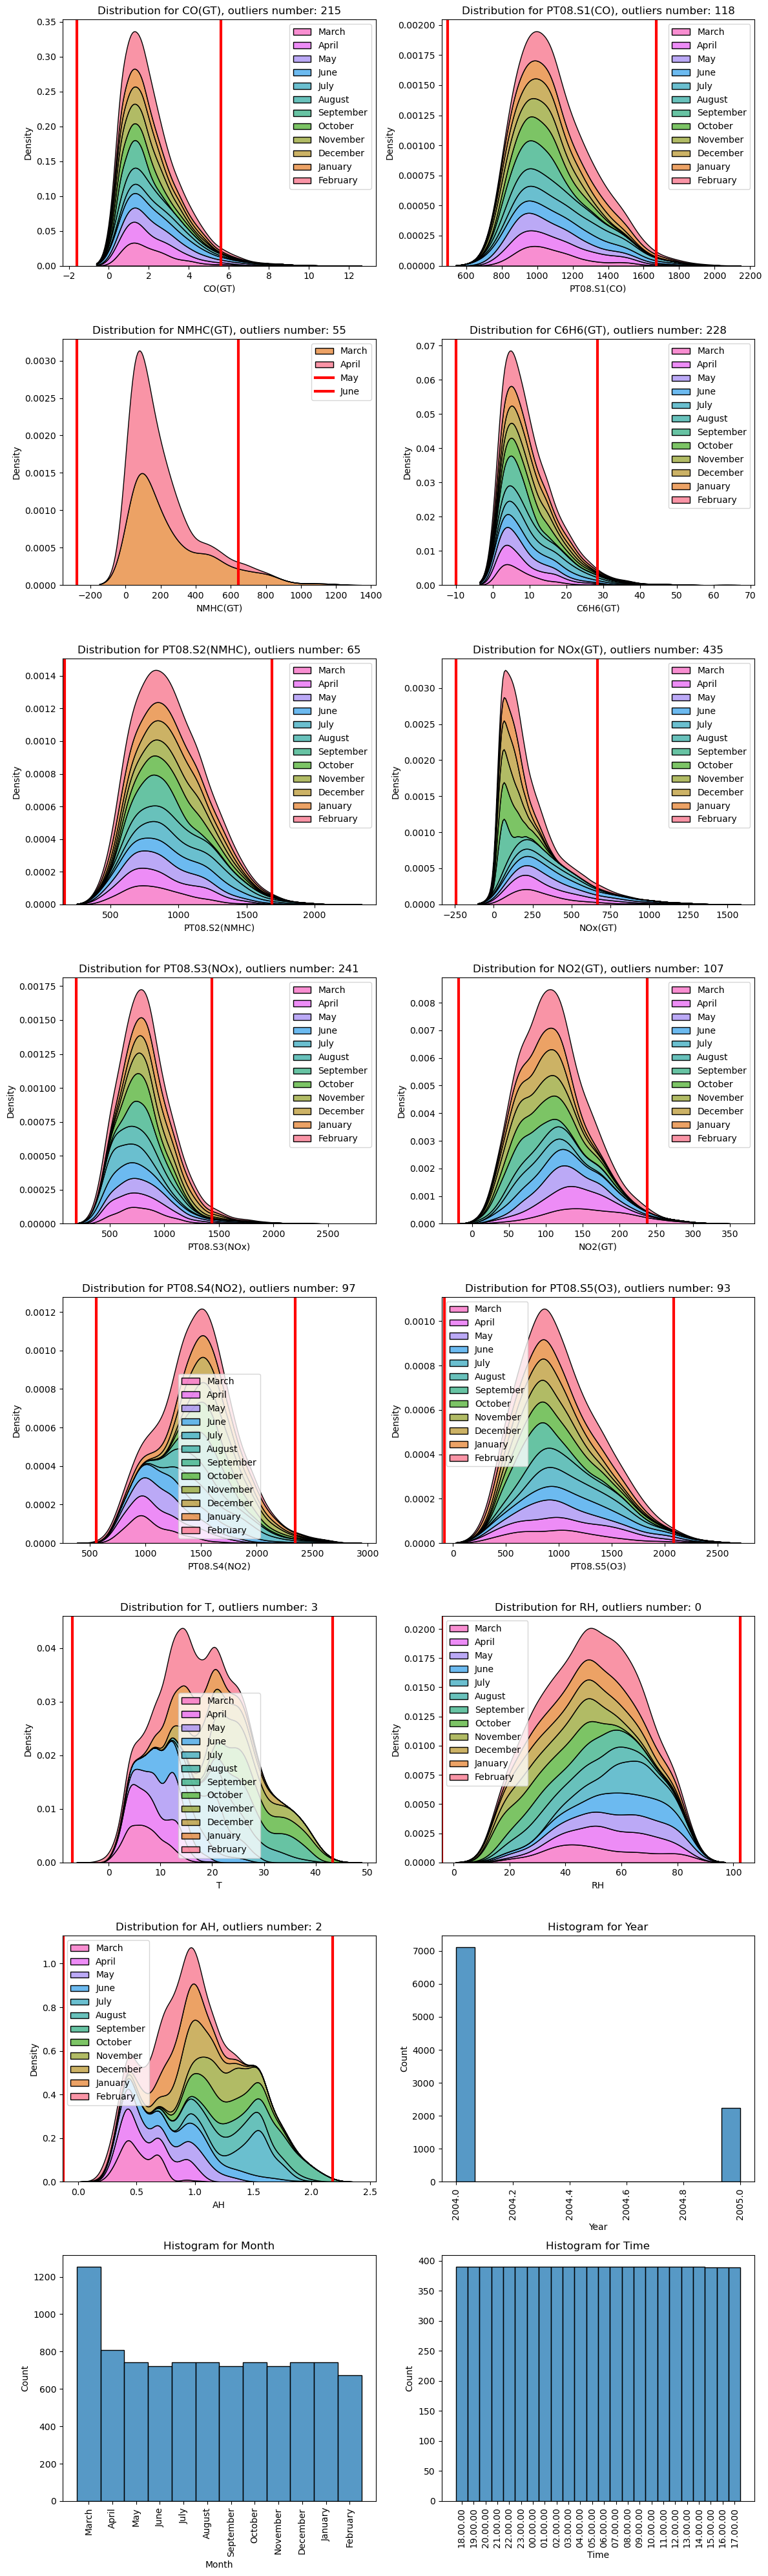

In [9]:
warnings.filterwarnings("ignore", category=FutureWarning)

fig, ax = plt.subplots(nrows=(len(data.columns.tolist()))//2,ncols=2,figsize=(12,40))

cols = np.concatenate((numerical_columns,categorical_columns), axis=None)
months = data['Month'].fillna('Unknown')
time = data['Time'].fillna('Unknown')



for i, column in enumerate(cols):#(data.columns.tolist()):

    row = i // 2
    col = i % 2



    #sns.histplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
    #ax[row,col].set_title(f'Histogram for {column}')

    if column in categorical_columns or column=='Year':
        #sns.barplot(data=data, x=column, y='y', estimator='count', ax=ax[row,col])
        sns.histplot(data=data, x=column, multiple='stack', ax=ax[row,col])
        ax[row,col].set_title(f'Histogram for {column}')
        ax[row,col].tick_params(axis='x', rotation=90)
    elif column in numerical_columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        #limits:
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        #outliers = data[column][(Q1 - 1.5 * IQR >= data[column]) |  (data[column] >= Q3 + 1.5 * IQR)].count()
        outliers = data[column][data[column] < Q1 - 1.5 * IQR].count() + data[column][data[column] > Q3 + 1.5 * IQR].count()
        #data = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]
        #data = data[data[column] >= lower_limit]
        sns.kdeplot(data=data, x=column, hue='Month', multiple='stack', ax=ax[row,col])
        #sns.histplot(data=data, x=column, hue='y', multiple='stack', ax=ax[row,col])
        ax[row,col].set_title(f'Distribution for {column}, outliers number: {outliers}')

        ax[row,col].axvline(upper_limit, linewidth=3 , color="red")
        ax[row,col].axvline(lower_limit, linewidth=3 , color="red")
        #ax[row,col].axvline(data[column].mean(), linewidth=3 , color="yellow")
        #ax[row,col].axvline(data[column].median(), linewidth=3 , color="black")

        #limits = mlines.Line2D([], [], color="red", linewidth=1, label="upper Limit, lower limit")
        #mean = mlines.Line2D([], [], color="yellow", linewidth=1, label="mean")
        #median = mlines.Line2D([], [], color="black", linewidth=1, label="median")
        #ax[row,col].legend(handles=[limits, mean, median],labels=data['Month'].unique())
        labelz = np.array(months.unique()) #np.array(time.unique())

        ax[row,col].legend(labels=labelz)

    
plt.tight_layout()
plt.show()

We can see that all the numerical features more or less could be approximated with a gaussian distribution.
Another thing is that we have much more data from 2004 year than from 2005 also around 50% more data from march than from other months. We can also assume that on each day data was taken every full hour.
<br>
<br>
It is clear that the month influences strongly our parameters.
<br>
<br>
Now lets check statistics for the numerical data:

In [10]:
data[numerical_columns].describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


In [11]:
data.dtypes

Year               int16
Month             object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object

Last thing we will do in this chapter is creating a new feature in place of feature 'Time'. We'll replace hours with the information if this was:
<br>
 - Morning (5:00-10:00)
 - Midday (11:00 - 16:00)
 - Evening (17:00 - 22:00)
 - Night (23:00 - 4:00)

In [12]:
def categorize_time(hour):
    if not pd.isnull(hour):
        hour = int(str(hour).split('.')[0])
        #hour = int(hour[:1])
        if 5 <= hour < 11:
            return 'Morning'
        elif 11 <= hour < 17:
            return 'Midday'
        elif 17 <= hour < 23:
            return 'Evening'
        else:  # For hours between 23 and 24, and 0 to 4
            return 'Night'
    else:
        return np.nan 
# Apply the categorization function to create a new column
data['time_of_day'] = data['Time'].apply(categorize_time)
data.drop(columns=['Time'], inplace=True)
categorical_columns = categorical_columns[categorical_columns != 'Time']
categorical_columns = np.append(categorical_columns, 'time_of_day')
data.head(5)

,Year,Month,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,time_of_day
0,2004,March,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,Evening
1,2004,March,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,Evening
2,2004,March,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,Evening
3,2004,March,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,Evening
4,2004,March,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,Evening


## <p style="font-size:30px"> 2. Multivariate analysis: consider features in pairs, try to introduce new features to consider their relationship with other features, correlation</p> 

First, lets inspect numerical values and plot correlation matrix of numerical features as a heatmap:

[[ 1.    0.88  0.89  0.93  0.92  0.8  -0.7   0.68  0.63  0.85  0.02  0.05
   0.05]
 [ 0.88  1.    0.79  0.88  0.89  0.71 -0.77  0.64  0.68  0.9   0.05  0.11
   0.14]
 [ 0.89  0.79  1.    0.9   0.88  0.81 -0.77  0.73  0.85  0.77  0.39 -0.19
   0.27]
 [ 0.93  0.88  0.9   1.    0.98  0.72 -0.74  0.61  0.77  0.87  0.2  -0.06
   0.17]
 [ 0.92  0.89  0.88  0.98  1.    0.7  -0.8   0.65  0.78  0.88  0.24 -0.09
   0.19]
 [ 0.8   0.71  0.81  0.72  0.7   1.   -0.66  0.76  0.23  0.79 -0.27  0.22
  -0.15]
 [-0.7  -0.77 -0.77 -0.74 -0.8  -0.66  1.   -0.65 -0.54 -0.8  -0.15 -0.06
  -0.23]
 [ 0.68  0.64  0.73  0.61  0.65  0.76 -0.65  1.    0.16  0.71 -0.19 -0.09
  -0.34]
 [ 0.63  0.68  0.85  0.77  0.78  0.23 -0.54  0.16  1.    0.59  0.56 -0.03
   0.63]
 [ 0.85  0.9   0.77  0.87  0.88  0.79 -0.8   0.71  0.59  1.   -0.03  0.12
   0.07]
 [ 0.02  0.05  0.39  0.2   0.24 -0.27 -0.15 -0.19  0.56 -0.03  1.   -0.58
   0.66]
 [ 0.05  0.11 -0.19 -0.06 -0.09  0.22 -0.06 -0.09 -0.03  0.12 -0.58  1.
   0.17]
 [ 0.0

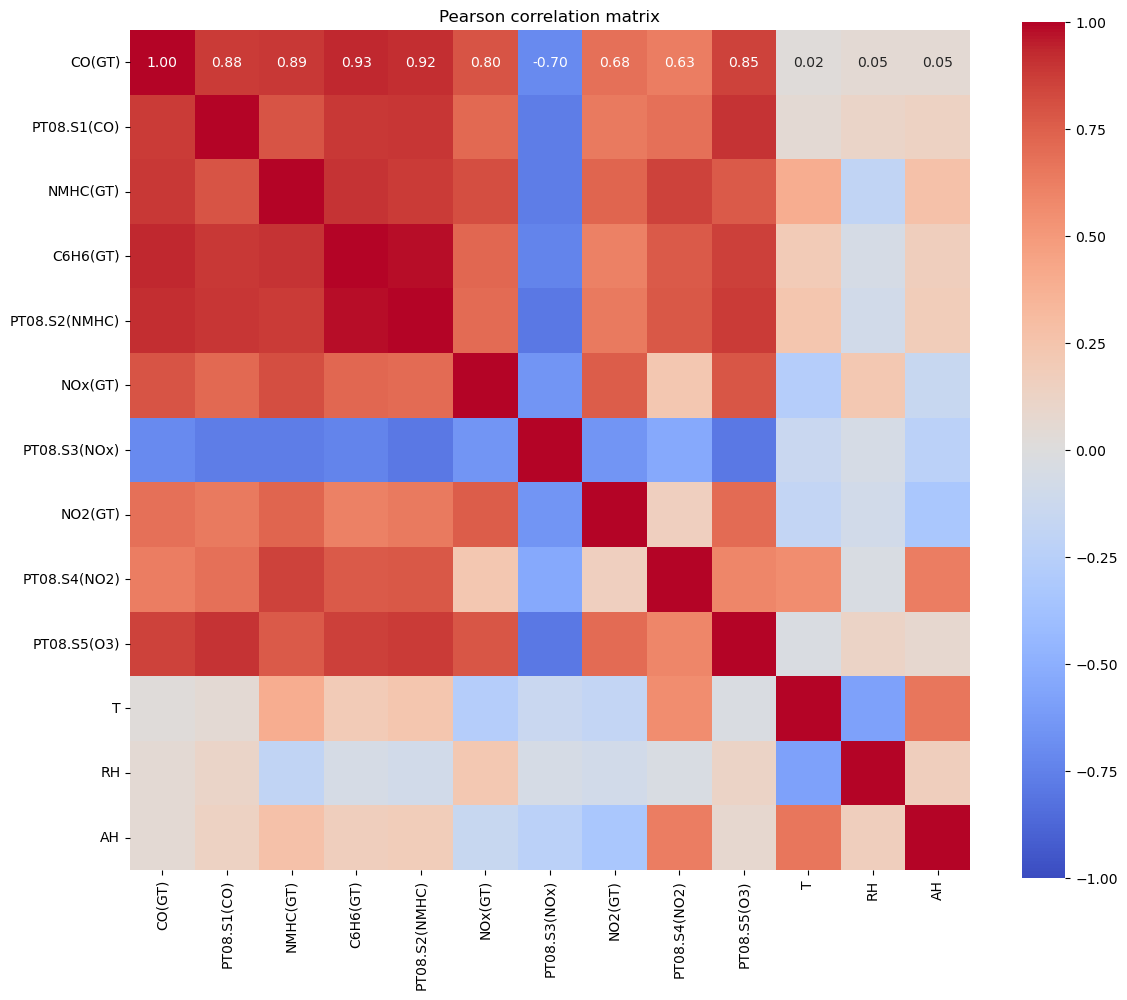

In [13]:
#data[numerical_columns].corr()['y'].sort_values(ascending=False)

#corr_matrix = data[numerical_columns].corr()
#corr_matrix["y"].sort_values(ascending=False)
plt.figure(figsize=(12, 10))
cor = data[list(numerical_columns)].corr()
sns.heatmap(cor, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f",annot=True, square=True)
plt.title("Pearson correlation matrix")
plt.tight_layout()
#plt.show()
print(np.round(cor.to_numpy(), 2))

#data.hist(figsize=(12,8))
#sns.boxplot( data=data)
#sns.pairplot(data)
#pd.plotting.scatter_matrix(data, figsize=(12,8))

And print explicitly correlations between features and target:

In [14]:
cor['C6H6(GT)'].sort_values(ascending=False)

C6H6(GT)         1.000000
PT08.S2(NMHC)    0.981950
CO(GT)           0.931078
NMHC(GT)         0.902559
PT08.S1(CO)      0.883795
PT08.S5(O3)      0.865689
PT08.S4(NO2)     0.765731
NOx(GT)          0.718839
NO2(GT)          0.614474
T                0.198956
AH               0.167972
RH              -0.061681
PT08.S3(NOx)    -0.735744
Name: C6H6(GT), dtype: float64

We can see pretty big correlations betwen some features and the target. Thats good.

Lets take a quick look at the pairplot.

KeyboardInterrupt: 

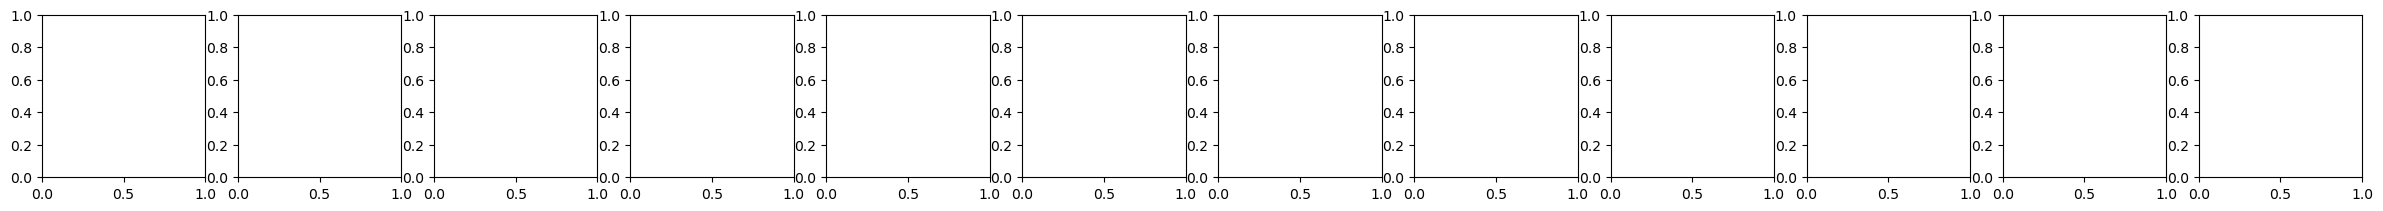

In [15]:
sns.pairplot(data)

Well it look a little bit like relation between 'PT08.S2(NMHC)' and target was quadratic. Also relation of 'PT08.S3(NOx)' with the target looks a little bit like 1/x curve. Lets try to introduce such features.

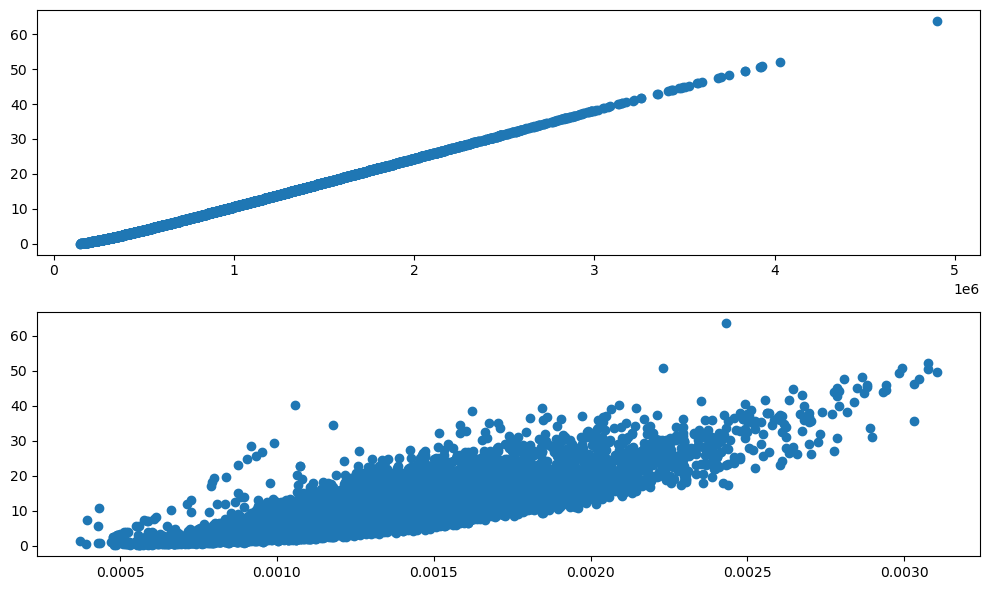

In [16]:
data['PT08.S2(NMHC)_squared'] = data['PT08.S2(NMHC)'] ** 2
data['1/PT08.S3(NOx)'] = 1 / data['PT08.S3(NOx)']

fig, ax = plt.subplots(2,figsize=(10,6))
ax[0].scatter(data['PT08.S2(NMHC)_squared'],data['C6H6(GT)'])
ax[1].scatter(data['1/PT08.S3(NOx)'],data['C6H6(GT)'])
plt.tight_layout()
plt.show()

The first one definitely went great. Second feature also seems to be more or less along a line. Lets drop original features then.

In [17]:
drop_cols = ['PT08.S2(NMHC)', 'PT08.S3(NOx)']
#data.drop(columns=drop_cols, inplace=True)
numerical_columns = numerical_columns[numerical_columns != drop_cols[0]]
numerical_columns = numerical_columns[numerical_columns != drop_cols[1]]
numerical_columns = np.append(numerical_columns, 'PT08.S2(NMHC)_squared')
numerical_columns = np.append(numerical_columns, '1/PT08.S3(NOx)')


Lets take a look at the dependency between our target and time of day it was measured.

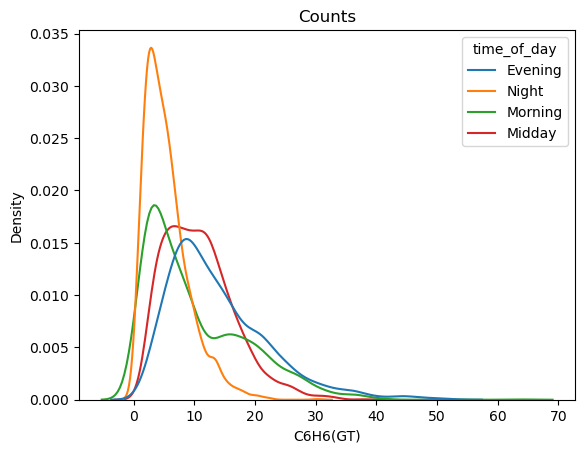

In [18]:
sns.kdeplot(x="C6H6(GT)", hue="time_of_day", data=data)
#plt.xticks(rotation=90)
plt.title("Counts")
plt.show()

It seems that we can expect lower C6H6 level at night. What about the year?

<Axes: xlabel='C6H6(GT)', ylabel='Count'>

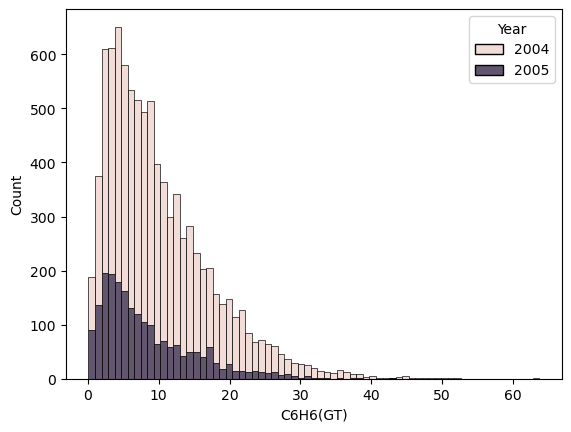

In [19]:
sns.histplot(data=data, x='C6H6(GT)',hue='Year', multiple='stack')

It seems that distributions are pretty similiar in 2004 and 2005.

In [20]:
data.dropna(subset=['Year','Month','time_of_day'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   9357 non-null   int16  
 1   Month                  9357 non-null   object 
 2   CO(GT)                 7674 non-null   float64
 3   PT08.S1(CO)            8991 non-null   float64
 4   NMHC(GT)               914 non-null    float64
 5   C6H6(GT)               8991 non-null   float64
 6   PT08.S2(NMHC)          8991 non-null   float64
 7   NOx(GT)                7718 non-null   float64
 8   PT08.S3(NOx)           8991 non-null   float64
 9   NO2(GT)                7715 non-null   float64
 10  PT08.S4(NO2)           8991 non-null   float64
 11  PT08.S5(O3)            8991 non-null   float64
 12  T                      8991 non-null   float64
 13  RH                     8991 non-null   float64
 14  AH                     8991 non-null   float64
 15  time

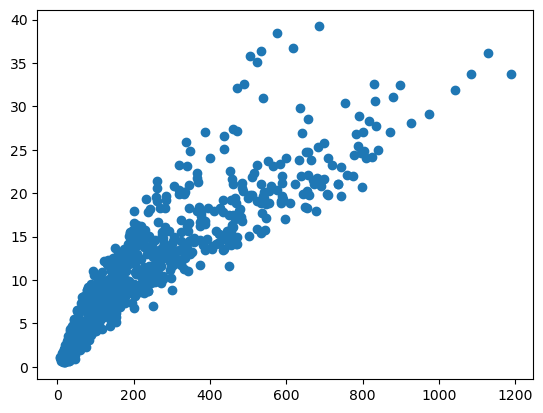

In [21]:
plt.scatter(data['NMHC(GT)'],data['C6H6(GT)'])

Over 90% of values in column 'NMHC(GT)' is missing. However it seems to be pretty correlated with our target. Obvious solution seems to be dropping it, but we will try to make something out of it.

# Part 2: Data Preparation 

Here we will prepare data for the model. We have already done some feature engineering (replacing 'Time' with 'time_of_day' and replacing 'Date' with 'Year' and 'Month')
<br>
<br>
Now we need to:
<br>
 - take care of missing values in numerical columns (using imputer)
<br>
 - encode categorical values (one-hot-encoding because ordinal doesn seem to suit us)
<br>
 - scale numerical features (features distribution are quite Gaussian-like therefore we will use StandardScaler)
<br>
 - maybe add polynomial features (from pairplot we can see that some relations between the target and feature are non-linear)

Lets drop rows with more than 5 null values

In [22]:
data = data.dropna(thresh=data.shape[1] - 5 + 1)


Now we will transform categorical features into numerical using one-hot encoding. This solution seems more suitable for such features like month or time of day because it hard to order them without incorrect or at least risky assumptions. We will of course use drop_first because for example if the measurement wasnt conducted in one of the 11 months it was certainly conducted in the 12th month.

In [23]:
data = pd.get_dummies(data,drop_first=True,columns=categorical_columns, dtype=int)
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,time_of_day_Midday,time_of_day_Morning,time_of_day_Night
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,...,0,0,1,0,0,0,0,0,0,0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,...,0,0,1,0,0,0,0,0,0,0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,...,0,0,1,0,0,0,0,0,0,0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,...,0,0,1,0,0,0,0,0,0,0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,...,0,0,1,0,0,0,0,0,0,0


Here we split our dataframe into separate dataframes X - our independent features and y - our target, dependent feature. We also apply train test split to leave some of data for the final test of our model.

In [24]:
feature_cols = data.columns
feature_cols = feature_cols[feature_cols != 'C6H6(GT)']
target_col = ['C6H6(GT)']


X = data[feature_cols]
y = data[target_col]
X = mf.utils.ampute_data(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In this step we impute missing numerical values using Multiple Imputation by Chained Equations (MICE) algorithm. It imputs values in one column based on the rest of columns and repeat this for every column and for a desired number of iterations (cycles) over all of columns.

In [25]:
pipe_kernel = mf.ImputationKernel(X_train, datasets=1)

mice_pipe = Pipeline([
    ('impute', pipe_kernel),
])

X_train_t = mice_pipe.fit_transform(
    X_train,
    impute__iterations=2
)

X_test_t = mice_pipe.transform(X_test)

# Show that neither now have missing values.
assert not np.any(np.isnan(X_train_t))
assert not np.any(np.isnan(X_test_t))

Scaling the numerical features using standard scales. We assume that our features come from a distribution close to a Gaussian.

In [26]:
numeric_transformer     = Pipeline([
('std_scaler', StandardScaler())
#('poly-features', PolynomialFeatures(degree=2))
])

numerical_columns_for_transformation = numerical_columns[numerical_columns != 'C6H6(GT)']

preprocessor            = ColumnTransformer([
    ('numeric_preprocess', numeric_transformer, numerical_columns_for_transformation),
]  , remainder='passthrough')


X_train_t = preprocessor.fit_transform(X_train_t)
X_test_t = preprocessor.transform(X_test_t)


In [27]:
X_train = pd.DataFrame(X_train_t, columns=feature_cols)
X_test = pd.DataFrame(X_test_t, columns=feature_cols)

X_train.head()

,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,time_of_day_Midday,time_of_day_Morning,time_of_day_Night
0,-1.040767,-1.340897,-0.897011,-0.897230,-1.309841,-0.364734,-1.483036,1.593711,-1.333166,0.555470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.177667,-0.457566,-0.017824,-0.121799,0.245388,0.947990,0.100099,1.502953,-1.460909,0.175982,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.682404,-0.596309,-0.836537,-0.836012,-0.621097,-0.431532,-1.206176,-0.686580,1.064922,-0.024310,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.539059,-0.795174,-0.715591,-0.438093,-0.087876,0.082521,-0.700278,0.584030,0.524917,1.585226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.109024,0.014160,0.196157,1.332135,1.867270,-1.163405,0.880341,-0.697925,-1.118325,-1.499078,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [28]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_train_t, y_train, test_size=0.2, random_state=2137)

In [29]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
#X_valid.reset_index(drop=True, inplace=True)
#y_valid.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Model training


Using cross validation we will now check if our model is able to generalize the solution for a new data.

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=2137)

# Create a list to store validation scores for each fold
r2_list = []
mae_list = []
rmse_list = []

# Loop through each fold in X and y
for train_ind, val_ind in cv.split(X_train, y_train):
    # Subset data based on CV folds
    X_train_v, y_train_v = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    # Fit the Model on fold's training data
    model = sm.OLS(y_train_v, X_train_v).fit()
    # Append Validation score to list 
    pred = model.predict(X_val)
    r2_list.append(r2_score(y_val, pred))
    mae_list.append(mean_absolute_error(y_val, pred))
    rmse_list.append(mean_squared_error(y_val, pred, squared = False))

print("All Validation R2s: ", [round(x, 3) for x in r2_list])
print(f"Cross Val R2s: {round(np.mean(r2_list), 3)}")

print("All Validation MAEs: ", [round(x, 3) for x in mae_list])
print(f"Cross Val MAEs: {round(np.mean(mae_list), 3)}")

print("All Validation RMSEs: ", [round(x, 3) for x in rmse_list])
print(f"Cross Val RMSEs: {round(np.mean(rmse_list), 3)}")

All Validation R2s:  [0.987, 0.99, 0.99, 0.983, 0.989]
Cross Val R2s: 0.988
All Validation MAEs:  [0.346, 0.342, 0.368, 0.358, 0.332]
Cross Val MAEs: 0.349
All Validation RMSEs:  [0.803, 0.749, 0.759, 0.972, 0.771]
Cross Val RMSEs: 0.811


Okay, perfect. We see that our model, based on given data is able to generalize pretty good. R2 scores are very high and consistent (just as both calculated errors).
<br>
So lets train model on whole training data and evaluate it:

In [31]:
model = sm.OLS(y_train, X_train).fit()
pred = model.predict(X_test)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               C6H6(GT)   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          5.886e+04
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:44:04   Log-Likelihood:                         -8640.8
No. Observations:                7192   AIC:                                  1.734e+04
Df Residuals:                    7163   BIC:                                  1.754e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CO(GT)                    0.3542      0.034     10.450      0.000       0.288       0.421
PT08.S1(CO)              -0.0057      0.037     -0.154      0.878      -0.079       0.067
NMHC(GT)                 -0.0853      0.037     -2.321      0.020      -0.157      -0.013
PT08.S2(NMHC)             0.0558      0.029      1.950      0.051      -0.000       0.112
NOx(GT)                  -0.0816      0.022     -3.737      0.000      -0.124      -0.039
PT08.S3(NOx)              1.3069      0.055     23.774      0.000       1.199       1.415
NO2(GT)                   0.0036      0.030      0.118      0.906      -0.056       0.063
PT08.S4(NO2)             -0.1959      0.037     -5.229      0.000      -0.269      -0.122
PT08.S5(O3)              -0.2732      0.028     -9.732      0.000      -0.328      -0.218
T                        -0.4100      0.036    -11.393      0.000      -0.481      -0.339
RH                        4.3190      0.050     86.993      0.000       4.222       4.416
AH                        0.9603      0.047     20.494      0.000       0.868       1.052
PT08.S2(NMHC)_squared     0.0069   8.79e-05     77.983      0.000       0.007       0.007
1/PT08.S3(NOx)            0.0036   9.05e-05     39.366      0.000       0.003       0.004
Year_2005                 1.1680      0.076     15.452      0.000       1.020       1.316
Month_August              0.4805      0.066      7.236      0.000       0.350       0.611
Month_December            0.8806      0.065     13.514      0.000       0.753       1.008
Month_February           -0.1714      0.071     -2.423      0.015      -0.310      -0.033
Month_January            -0.1023      0.068     -1.503      0.133      -0.236       0.031
Month_July                0.2563      0.059      4.354      0.000       0.141       0.372
Month_June                0.0265      0.058      0.454      0.650      -0.088       0.141
Month_March              -0.3273      0.050     -6.553      0.000      -0.425      -0.229
Month_May                -0.0976      0.047     -2.079      0.038      -0.190      -0.006
Month_November            1.0665      0.063     16.999      0.000       0.943       1.189
Month_October             0.8759      0.061     14.317      0.000       0.756       0.996
Month_September           0.7093      0.059     12.082      0.000       0.594       0.824
time_of_day_Midday       -0.0687      0.029     -2.348      0.019      -0.126      -0.011
time_of_day_Morning       0.0791      0.031      2.584      0.010       0.019       0.139
time_of_day_Night         0.1678      0.032      5.172      0.000       0.104       0.231
==============================================================================
Omnibus:                 

This looks almost good, but there is one problem left. Plenty of features exceed p_value of 5% drastically. We will now drop them.

In [32]:
#features = [col for col in X_train.columns if col not in ('price', 'y', 'z')]

significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()

X_train = X_train[significant_features]
X_test  = X_test[significant_features]


Lets train model once again using only statistically significant features.

In [33]:
model = sm.OLS(y_train, X_train).fit()
pred = model.predict(X_test)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               C6H6(GT)   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                          7.110e+04
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                        0.00
Time:                        22:44:04   Log-Likelihood:                         -8644.3
No. Observations:                7192   AIC:                                  1.734e+04
Df Residuals:                    7168   BIC:                                  1.750e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
CO(GT)                    0.3630      0.033     11.092      0.000       0.299       0.427
NMHC(GT)                 -0.0793      0.037     -2.163      0.031      -0.151      -0.007
NOx(GT)                  -0.0611      0.019     -3.210      0.001      -0.098      -0.024
PT08.S3(NOx)              1.2773      0.051     24.867      0.000       1.177       1.378
PT08.S4(NO2)             -0.1849      0.037     -5.056      0.000      -0.257      -0.113
PT08.S5(O3)              -0.2670      0.027     -9.885      0.000      -0.320      -0.214
T                        -0.4016      0.035    -11.361      0.000      -0.471      -0.332
RH                        4.3412      0.047     91.634      0.000       4.248       4.434
AH                        0.9950      0.043     22.940      0.000       0.910       1.080
PT08.S2(NMHC)_squared     0.0068   7.99e-05     85.222      0.000       0.007       0.007
1/PT08.S3(NOx)            0.0036   8.41e-05     42.907      0.000       0.003       0.004
Year_2005                 1.0969      0.064     17.196      0.000       0.972       1.222
Month_August              0.4578      0.053      8.636      0.000       0.354       0.562
Month_December            0.8978      0.064     14.034      0.000       0.772       1.023
Month_February           -0.1113      0.049     -2.286      0.022      -0.207      -0.016
Month_July                0.2352      0.045      5.187      0.000       0.146       0.324
Month_March              -0.2910      0.034     -8.580      0.000      -0.358      -0.225
Month_May                -0.0979      0.040     -2.426      0.015      -0.177      -0.019
Month_November            1.0853      0.061     17.798      0.000       0.966       1.205
Month_October             0.8725      0.056     15.472      0.000       0.762       0.983
Month_September           0.7088      0.050     14.054      0.000       0.610       0.808
time_of_day_Midday       -0.0664      0.029     -2.323      0.020      -0.122      -0.010
time_of_day_Morning       0.0911      0.030      3.047      0.002       0.032       0.150
time_of_day_Night         0.1728      0.032      5.486      0.000       0.111       0.235
==============================================================================
Omnibus:                     7518.500   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21130123.549
Skew:                           3.968   Prob(JB):                         0.00
Kurtosis:                     268.422   Cond. No.                     1.64e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does n

Lets evaluate this model. We will use mean squared error, because it seems that for such model it might be better to make many slight mistakes in predictions rather than a few big mistakes.

In [34]:
print('mean_squared_error:  ', mean_squared_error(y_test,pred))
print('R2 score:  ', r2_score(y_test,pred))

mean_squared_error:   0.4928497467173755
R2 score:   0.9914230573760671


Wow, the R2 score is very high. It means that we managed to explain almost all correlation between the data and target. Error also has been reduced to etremely small value. We can say with high confidence that our model will generalize well.